In [3]:
import tensorflow
from tensorflow import keras
from tensorflow.keras.layers import Input,  Dense, Embedding, Flatten

In [4]:
from tensorflow.keras.models import Model

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
season = pd.read_csv('/content/games_season.csv')
season.head(2)

,season,team_1,team_2,home,score_diff,score_1,score_2,won
0,1985,3745,6664,0,17,81,64,1
1,1985,126,7493,1,7,77,70,1


In [8]:
tourney= pd.read_csv('/content/games_tourney.csv')

In [9]:
input1 = Input(shape=(1,))

In [10]:
output1 = Dense(1)(input1)

In [11]:
model1 = Model(input1, output1)

In [12]:
model1.compile('adam', loss='mean_absolute_error')

In [14]:
model1.fit(tourney['seed_diff'], tourney['score_diff'], epochs=100, batch_size=1000, verbose=False)

In [15]:
model1.evaluate(tourney['seed_diff'], tourney['score_diff'], verbose=0)

9.236357688903809

In [16]:
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


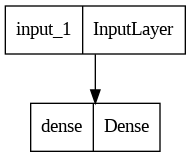

In [20]:
plot_model(model1)

In [25]:
from sklearn.model_selection import train_test_split

In [26]:
season_train, season_test, _, _= train_test_split(season, season, test_size=.2)

In [28]:
season_train.head(2)

,season,team_1,team_2,home,score_diff,score_1,score_2,won
35382,1993,7331,3567,1,11,89,78,1
33680,1993,4881,5085,1,12,78,66,1


In [29]:
toruney_train, tourney_test, _, _ =  train_test_split(tourney, tourney, test_size=0.2)

Was wir machen ist mal das erste Modell aus dem Kopf bauen wo wir Die Ids als Input haben, ein Embed Layer erstellen was die Stärke des teams representieren soll. Und daraus bauen wir ein Output Layer, das uns die Score Differenz geben soll. Als input erhalten wir die beiden Team IDs.

In [178]:
input2 = Input(shape=(1,))

In [179]:
np.unique(season['team_1']).shape[0]

2914

In [180]:
output_embed_layer = Embedding(input_dim=2914, input_length=1, output_dim=1, name='Embed-Layer-Strength')(input2)

In [181]:
embed_flatten= Flatten()(output_embed_layer)

In [182]:
model_embed = Model(input2, embed_flatten)

In [183]:
Input_team1= Input(shape=(1,))

In [184]:
Input_team2 = Input(shape=(1,))

In [185]:
strength_team1= model_embed(Input_team1)

In [186]:
strength_team2= model_embed(Input_team2)

In [187]:
subtract_res = Subtract()([strength_team1, strength_team2])

In [188]:
Output= Dense(1)(subtract_res)

In [189]:
model2 = Model([Input_team1, Input_team2], Output)

In [190]:
model2.compile(optimizer='adam', loss='mean_absolute_error')

In [191]:
model2.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_27 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_28 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 model_1 (Functional)           (None, 1)            2914        ['input_27[0][0]',               
                                                                  'input_28[0][0]']               
                                                                                                  
 subtract_10 (Subtract)         (None, 1)            0           ['model_1[0][0]',          

In [192]:
model2.fit([season_train['team_1'], season_train['team_2']], season_train['score_diff'], epochs=1, batch_size=2000, validation_split=0.1, verbose=0)

InvalidArgumentError: ignored

In [150]:
n_teams = np.unique(season['team_1']).shape[0]
n_teams

2914

In [166]:
input = Input(shape=(1,))

In [167]:
embed_tensor = Embedding(input_dim=n_teams, input_length=1, output_dim=1, name='Team-strength-lookup')(input)

In [168]:
flatten_tensor = Flatten()(embed_tensor)

In [169]:
model_embed = Model(input, flatten_tensor, name='input-embedd-ranking')

Also wir haben ein Modell erstellt, dass ein Embed Layer erstellt und den output flattened. Nun können wir diese Funktion auf beiden Inputs anwenden. Das ergibt uns die Strength der Teams, diese müssen wir dann nun voneinander subtrahieren. Dann können wir das alles in einem Einzigen Modell zusammennehmen. 

In [170]:
input_1 = Input(shape=(1,), name='Team1_in')
input_2 = Input(shape=(1,), name='Team2_in')

In [171]:
output_tensor_strength1 = model_embed(input_1)
output_tensor_strength2 = model_embed(input_2)

In [172]:
from tensorflow.keras.layers import Subtract

In [173]:
output_subtract = Subtract()([output_tensor_strength1, output_tensor_strength2])

In [174]:
model = Model([input_1, input_2], output_subtract, name='Abziehen-der-Rankings')

In [175]:
model.compile('adam', 'mean_absolute_error')

In [177]:
model.fit([season['team_1'], season['team_2']], season['score_diff'], epochs=1, batch_size=2000, validation_split=0.1)

InvalidArgumentError: ignored

Also eigentlich nimmt das Modell die ID der Teams und weist ihnen eine Strength zu, und wenn die Strength voneinander subtrahiert werden, dann erhaltet man den score? schon etwas merkwürdig das ganze. Ich hätte wenigstens erwarte dass noch eine Schicht folgt

In [80]:
team_1 = tourney['team_1'][:2]
team_1

0     288
1    5929
Name: team_1, dtype: int64

In [76]:
team_2 = tourney['team_2'][:2]

In [77]:
model.predict([team_1, team_2] )

1/1 [==============================] - 0s 106ms/step


array([[-0.06611039],
       [-0.04766534]], dtype=float32)

In [84]:
model.evaluate([team_1, team_2], tourney['score_diff'][:2], verbose=1)


1/1 [==============================] - 0s 69ms/step - loss: 7.4908


7.490777015686035

In [79]:
tourney[:2]

,season,team_1,team_2,home,seed_diff,score_diff,score_1,score_2,won
0,1985,288,73,0,-3,-9,41,50,0
1,1985,5929,73,0,4,6,61,55,1


In [19]:
from tensorflow.keras.utils import plot_model

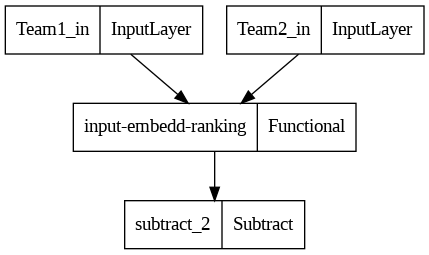

In [90]:
plot_model(model, 'model_basket1.png')

In [91]:
model.summary()

Model: "Abziehen der Rankings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Team1_in (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 Team2_in (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input-embedd-ranking (Function  (None, 1)           10888       ['Team1_in[0][0]',               
 al)                                                              'Team2_in[0][0]']               
                                                                                                  
 subtract_2 (Subtract)          (None, 1)            0           ['input-embed